# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
#Imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import gzip
import os
import sys
import time
import pickle
import numpy
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
from sklearn.utils import shuffle
from PIL import Image
import cv2
from os import listdir
from os.path import isfile, join
from tensorflow.contrib.layers import flatten

In [2]:
training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

train_data, train_labels = shuffle(train['features'], train['labels'])
test_data, test_labels = shuffle(test['features'], test['labels'])

print(train_data.shape)
print(test_data.shape)

(39209, 32, 32, 3)
(12630, 32, 32, 3)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

n_train = train_data.shape[0]
n_test = test_data.shape[0]
image_shape = train_data[0].shape
n_classes = numpy.unique(train_labels).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

2


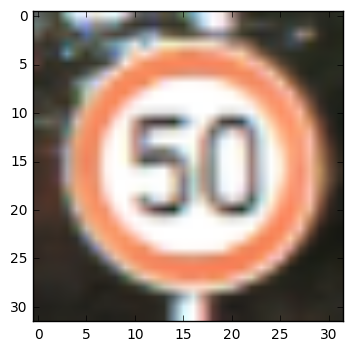

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import matplotlib.pyplot as plt

index = random.randint(0, len(train_data))
image = train_data[index]
print(train_labels[index])
plt.imshow(image)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
def normalize_data(data):
    return numpy.array([numpy.float32((datum[:]-numpy.mean(datum))/numpy.std(datum)) for datum in data])

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
The loss was very large with non-normalized data and model was not converging. So had to normalize the data. I subtracted the mean and devided by standard deviation of the pixel values in the image 
to make sure that the data being processed has zero mean and equal variance. This approch gave me better results than (x-128)/128.
I didn't convert the image to grayscale as I thought unlike digit images, traffic signs are not just about edges and shapes, color matters too.

In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
validation_size = int(train_data.shape[0] * 0.2)
validation_data = train_data[:validation_size, ...]
validation_labels = train_labels[:validation_size]
train_data = train_data[validation_size:, ...]
train_labels = train_labels[validation_size:]
train_size = train_labels.shape[0]

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
I sliced out 20% of the training dataset as validation set.

In [7]:
IMAGE_SIZE = 32
NUM_CHANNELS = 3
NUM_LABELS = 43
SEED = 66478
BATCH_SIZE = 512
NUM_EPOCHS = 50

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def data_type():
    return tf.float32

train_data_node = tf.placeholder(
      data_type(),
      shape=(None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
train_labels_node = tf.placeholder(tf.int64, shape=(None,))
eval_data = tf.placeholder(
      data_type(),
      shape=(None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))

conv1_weights = tf.Variable(
      tf.truncated_normal([5, 5, NUM_CHANNELS, 32],
                          stddev=0.1,
                          seed=SEED, dtype=data_type()))
conv1_biases = tf.Variable(tf.zeros([32], dtype=data_type()))
conv2_weights = tf.Variable(tf.truncated_normal(
      [5, 5, 32, 64], stddev=0.1,
      seed=SEED, dtype=data_type()))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64], dtype=data_type()))

conv3_weights = tf.Variable(tf.truncated_normal(
      [5, 5, 64, 128], stddev=0.1,
      seed=SEED, dtype=data_type()))
conv3_biases = tf.Variable(tf.constant(0.1, shape=[128], dtype=data_type()))

fc1_weights = tf.Variable(
      tf.truncated_normal([IMAGE_SIZE // 8 * IMAGE_SIZE // 8 * 128, 512],
                          stddev=0.1,
                          seed=SEED,
                          dtype=data_type()))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512], dtype=data_type()))
fc2_weights = tf.Variable(tf.truncated_normal([512, 256],
                                                stddev=0.1,
                                                seed=SEED,
                                                dtype=data_type()))
fc2_biases = tf.Variable(tf.constant(
      0.1, shape=[256], dtype=data_type()))

fc3_weights = tf.Variable(tf.truncated_normal([256, 128],
                                                stddev=0.1,
                                                seed=SEED,
                                                dtype=data_type()))
fc3_biases = tf.Variable(tf.constant(
      0.1, shape=[128], dtype=data_type()))

fc4_weights = tf.Variable(tf.truncated_normal([128, NUM_LABELS],
                                                stddev=0.1,
                                                seed=SEED,
                                                dtype=data_type()))
fc4_biases = tf.Variable(tf.constant(
      0.1, shape=[NUM_LABELS], dtype=data_type()))

In [9]:
train_data_node = tf.placeholder(
        data_type(),
        shape=(None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
train_labels_node = tf.placeholder(tf.int64, shape=(None,))
eval_data = tf.placeholder(
        data_type(),
        shape=(None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))

conv1_weights = tf.Variable(
        tf.truncated_normal([5, 5, NUM_CHANNELS, 32],
                stddev=0.1,
                seed=SEED, dtype=data_type()))
conv1_biases = tf.Variable(tf.zeros([32], dtype=data_type()))
conv2_weights = tf.Variable(tf.truncated_normal(
        [5, 5, 32, 64], stddev=0.1,
        seed=SEED, dtype=data_type()))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64], dtype=data_type()))

conv3_weights = tf.Variable(tf.truncated_normal(
        [5, 5, 64, 128], stddev=0.1,
        seed=SEED, dtype=data_type()))
conv3_biases = tf.Variable(tf.constant(0.1, shape=[128], dtype=data_type()))

fc1_weights = tf.Variable(
        tf.truncated_normal([IMAGE_SIZE // 8 * IMAGE_SIZE // 8 * 128, 512],
                stddev=0.1,
                seed=SEED,
                dtype=data_type()))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512], dtype=data_type()))
fc2_weights = tf.Variable(tf.truncated_normal([512, 256],
        stddev=0.1,
        seed=SEED,
        dtype=data_type()))

fc2_biases = tf.Variable(tf.constant(
        0.1, shape=[256], dtype=data_type()))

fc3_weights = tf.Variable(tf.truncated_normal([256, 128],
        stddev=0.1,
        seed=SEED,
        dtype=data_type()))
fc3_biases = tf.Variable(tf.constant(
        0.1, shape=[128], dtype=data_type()))

fc4_weights = tf.Variable(tf.truncated_normal([128, NUM_LABELS],
        stddev=0.1,
        seed=SEED,
        dtype=data_type()))
fc4_biases = tf.Variable(tf.constant(
        0.1, shape=[NUM_LABELS], dtype=data_type()))

In [10]:
def model(data, train=False):
    """The Model definition."""
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

    conv = tf.nn.conv2d(pool,
                        conv3_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv3_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

    reshape = flatten(pool)
    fc1 = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
    fc2 = tf.nn.relu(tf.matmul(fc1, fc2_weights) + fc2_biases)
    fc3 = tf.nn.relu(tf.matmul(fc2, fc3_weights) + fc3_biases)

    if train:
        fc3 = tf.nn.dropout(fc3, 0.5, seed=SEED)
    return tf.matmul(fc3, fc4_weights) + fc4_biases

In [11]:
logits = model(train_data_node, True)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, train_labels_node))

regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                  tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
loss += 5e-3 * regularizers

optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
train_prediction = tf.nn.softmax(logits)
eval_prediction = tf.nn.softmax(model(eval_data))

In [12]:
def eval_in_batches(data, sess):
    """Get all predictions for a dataset by running it in small batches."""
    size = data.shape[0]
    predictions = numpy.ndarray(shape=(size, NUM_LABELS), dtype=numpy.float32)
    for begin in xrange(0, size, BATCH_SIZE):
        end = begin + BATCH_SIZE
        if end <= size:
            batch_data = normalize_data(data[begin:end, ...])
            predictions[begin:end, :] = sess.run(
                eval_prediction,
                feed_dict={eval_data: batch_data})
        else:
            batch_data = normalize_data(data[-BATCH_SIZE:, ...])
            batch_predictions = sess.run(
                eval_prediction,
                feed_dict={eval_data: batch_data})
            predictions[begin:, :] = batch_predictions[begin - size:, :]
    return predictions

In [13]:
def error_rate(predictions, labels):
  """Return the error rate based on dense predictions and sparse labels."""
  return 100.0 - (
      100.0 *
      numpy.sum(numpy.argmax(predictions, 1) == labels) /
      predictions.shape[0])

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** 
The LeNet architecture in the LeNet solution module was dealing with 32x32x1 image and I am dealing with 32x32x3 image which made me think the layers need to be modifiled since there is more information in the image now. The original architecture was 
```
32x32x1 -> 14x14x6 -> 5x5x16 -> 120 -> 84 -> 10
```
I added one conv layer and one fully connected layer and changed the values of the output of layers as well. The final model looks like below
```
32x32x3 -> 16x16x32 -> 8x8x64 -> 4x4x128 -> 512 -> 256 -> 128 -> 43
```

In [14]:
def resizeImage32x32(folder, file_name):
    with open(folder + "/" + file_name, 'r+b') as f:
        with Image.open(f) as image:
            image = image.resize((32, 32), Image.ANTIALIAS)
            return numpy.array(image.convert("RGB"))


def openImagesAtPath(folder_path):
    image_files = [ f for f in listdir(folder_path) if (isfile(join(folder_path,f)) and (f.endswith(".png") or f.endswith(".jpg"))) ]
    images = numpy.empty(len(image_files), dtype=object)
    for n in range(0, len(image_files)):
        print(image_files[n])
        images[n] = resizeImage32x32(folder_path, image_files[n])
    return image_files, numpy.array([i for i in images])

Initialized!
Epoch 0, 29.2 seconds
Minibatch loss: 21.170
Minibatch error: 91.9%
Validation error: 80.4%
Epoch 1, 28.6 seconds
Minibatch loss: 16.892
Minibatch error: 72.8%
Validation error: 57.8%
Epoch 2, 28.6 seconds
Minibatch loss: 13.644
Minibatch error: 47.1%
Validation error: 39.2%
Epoch 3, 28.6 seconds
Minibatch loss: 11.503
Minibatch error: 33.1%
Validation error: 26.4%
Epoch 4, 28.6 seconds
Minibatch loss: 10.017
Minibatch error: 33.8%
Validation error: 19.1%
Epoch 5, 29.1 seconds
Minibatch loss: 8.593
Minibatch error: 25.7%
Validation error: 12.1%
Epoch 6, 29.2 seconds
Minibatch loss: 7.283
Minibatch error: 14.7%
Validation error: 10.0%
Epoch 7, 29.2 seconds
Minibatch loss: 6.525
Minibatch error: 10.3%
Validation error: 5.9%
Epoch 8, 29.3 seconds
Minibatch loss: 5.731
Minibatch error: 8.1%
Validation error: 4.8%
Epoch 9, 29.2 seconds
Minibatch loss: 5.083
Minibatch error: 5.9%
Validation error: 4.2%
Epoch 10, 29.2 seconds
Minibatch loss: 4.508
Minibatch error: 7.4%
Validation

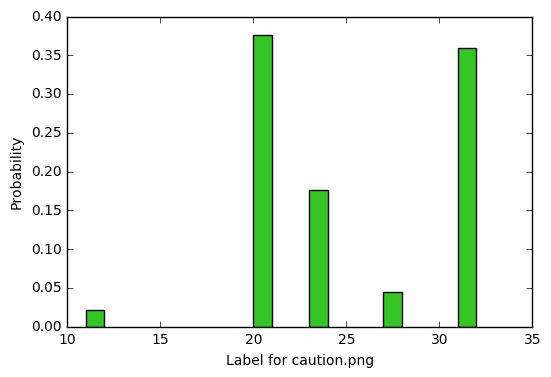

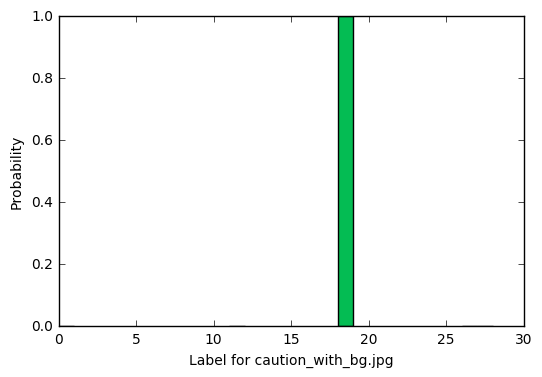

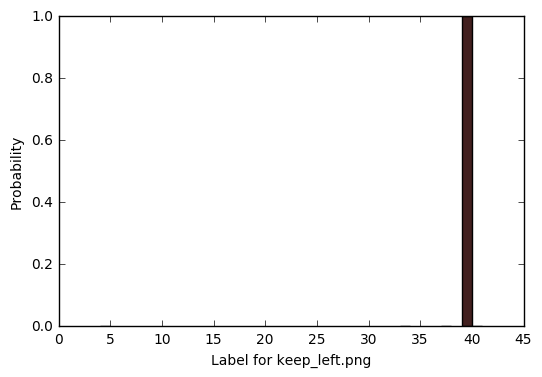

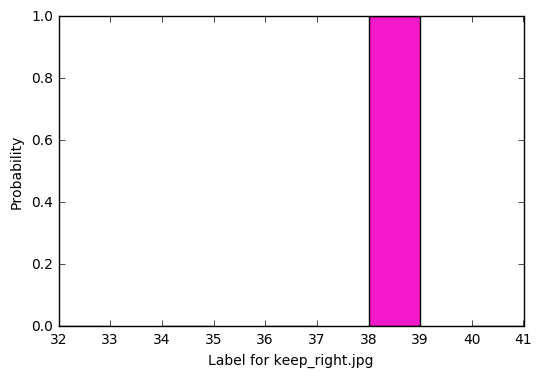

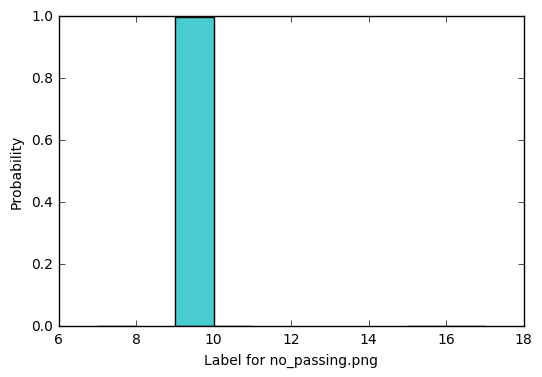

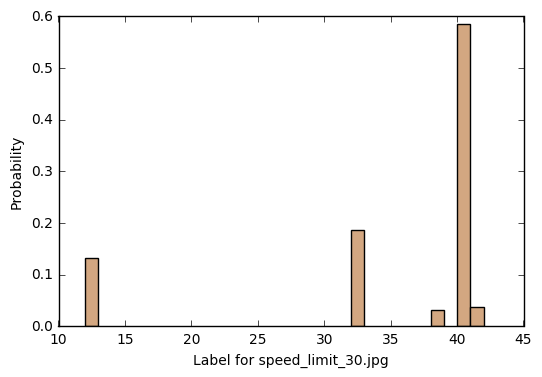

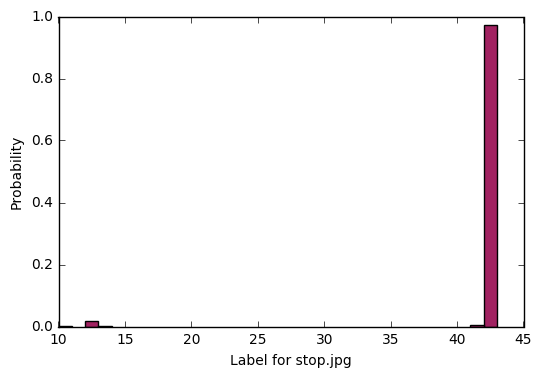

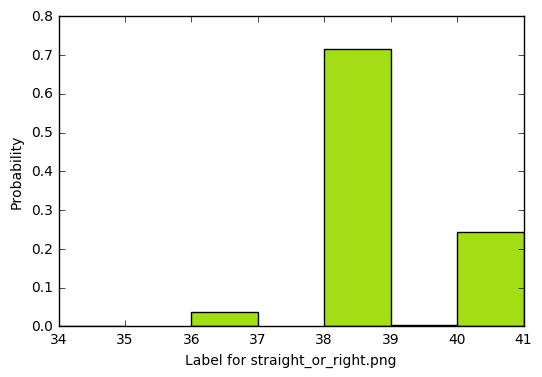

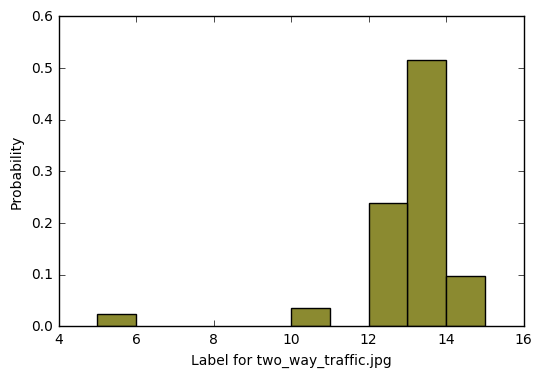

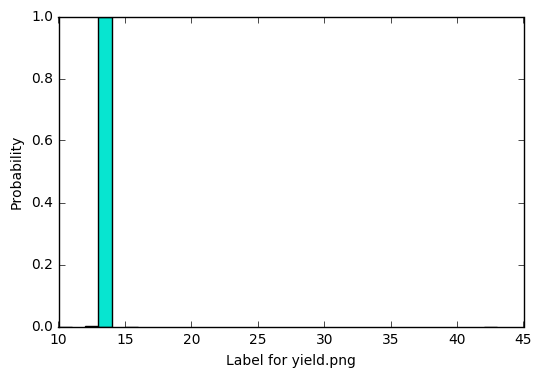

In [17]:
### Train your model here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print('Initialized!')

    for i in range(0, NUM_EPOCHS):
        train_data, train_labels = shuffle(train_data, train_labels)
        start_time = time.time()
        train_size = len(train_data)

        for offset in range(0, train_size, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_data, batch_labels = train_data[offset:end], train_labels[offset:end]
            batch_data = normalize_data(batch_data)
            feed_dict = {train_data_node: batch_data, train_labels_node: batch_labels}
            sess.run(optimizer, feed_dict=feed_dict)

        l, predictions = sess.run([loss, train_prediction], feed_dict=feed_dict)
        elapsed_time = time.time() - start_time

        print('Epoch %d, %.1f seconds' % (i, elapsed_time))
        print('Minibatch loss: %.3f' % l)
        print('Minibatch error: %.1f%%' % error_rate(predictions, batch_labels))
        print('Validation error: %.1f%%' % error_rate(
            eval_in_batches(validation_data, sess), validation_labels))
        sys.stdout.flush()

    test_error = error_rate(eval_in_batches(test_data, sess), test_labels)
    print('Test error: %.1f%%' % test_error)
    
    #test my images downloaded from internet
    image_names, images = openImagesAtPath("my_images/")
    images = normalize_data(images)
    test_top_k = sess.run(tf.nn.top_k(tf.nn.softmax(model(images)), 5), feed_dict={eval_data:images})
    values, indices = test_top_k.values, test_top_k.indices
    print (values)
    print (indices)
    
    for i in range(0, len(image_names)):
        fig = plt.figure(i)
        fig.canvas.set_window_title('Image - %d' % i)
        bar = plt.bar(indices[i], values[i],
        label=('%d' % i), color=numpy.random.rand(3,1), width=1)
        plt.xlabel('Label for %s' % image_names[i])
        plt.ylabel('Probability')
    plt.show()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I tried using momentum optimizer with exponentially decaying learning rate but adam optimizer with learning rate 0.001 worked out best for me. With momentum optimizer I needed more epochs to get better results. With Adam optimizer, I seem to have good results with epoch = 10 but there was one image from those I downloaded from internet that was not getting classified correctly. I went up to epoch 50 where the image's class makes it to top 5 predictions.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I didn't get satisfactory results when I first submitted the project and continued to work on it even after the submission. So I defined my own model completely discarding the LeNet solution that was given in the lessions. Experimented with different hidden layers and finally got better results with 3 conv layers and 4 fully connected layers.

Also, I found out that the problem with earlier submission seems to be with Saver where I was saving the model after training and loading it back to test the images I downloaded from internet and none of the image was rightly getting classified. But when I tested those images right after training, I am getting better results.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

caution.png
caution_with_bg.jpg
keep_left.png
keep_right.jpg
no_passing.png
straight_or_right.png
yield.png


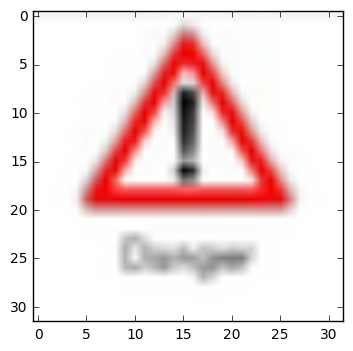

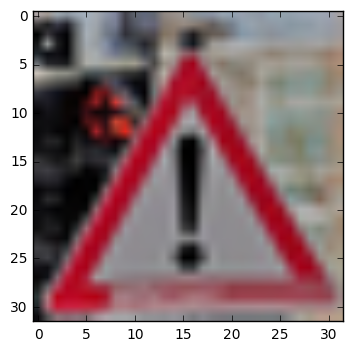

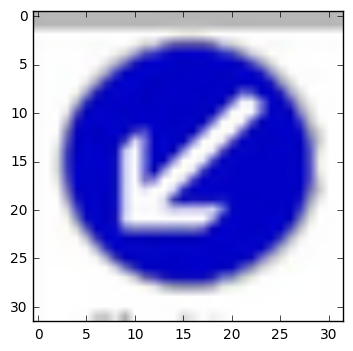

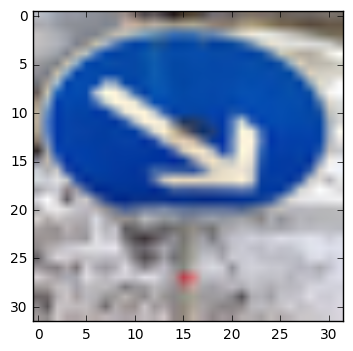

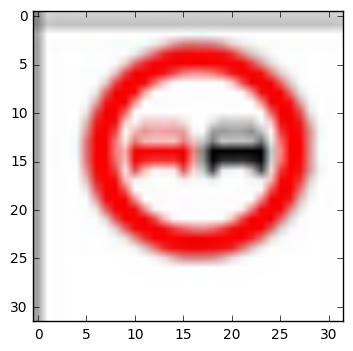

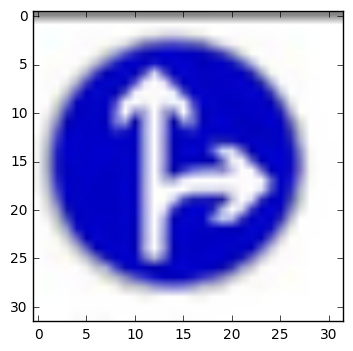

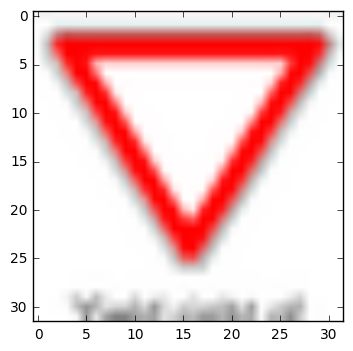

In [16]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
names, images = openImagesAtPath("my_images/")
for img in images:
    plt.imshow(img)
    plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
There seem to be some issue with saving and loading. None of the images were getting classified correcly if tested with model that was saved after training. So I tested them right after training and it worked. So nothing to run here.
The images I choose were were fit to the edge and most images in the train set had some padding across it which made me choose those ones. Also I made sure to include couple of real life images with street background and also an image that was having a big street image with a car and small stop sign at the top right corner which was slightly titled. 

In [21]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The model seems to be about 50% accurate when tested on the images donwloaded from the internet. I had 10 images donwloaded with different qualities and about half of them got classified correctly.

The accuracy when tested against the available data set was about 94% but for the images donwloaded from internet got down to 50%. One reason I can think of is, while resizing the images to 32x32, most of the data is lost and the actual sign image is getting skewed. Also not sure if trainig data only contains images from one particular angle then whether the trained model will be able to predict images from different angle correctly or not.

In [22]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

The probablities have been visualized right after the model was trained and tested in the block above

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
Below are the results for the images downloaded from internet and tested right after training(Can be found in the logs of train block).

The visualization has been provided right after the model was trained and tested on the images from internet in block above.

```
caution.png
caution_with_bg.jpg
keep_left.png
keep_right.jpg
no_passing.png
speed_limit_30.jpg
stop.jpg
straight_or_right.png
two_way_traffic.jpg
yield.png
[[  3.75822842e-01   3.59011650e-01   1.76682651e-01   4.42668572e-02
    2.13817824e-02]
 [  9.99962211e-01   3.13672281e-05   6.38469601e-06   1.13438703e-09
    9.72198433e-11]
 [  9.99996305e-01   3.33707067e-06   2.55407485e-07   1.54060629e-07
    1.05524722e-09]
 [  9.99915719e-01   4.13490743e-05   3.99990422e-05   2.23038842e-06
    6.42137593e-07]
 [  9.97850657e-01   2.14917003e-03   2.75916705e-07   9.44443013e-09
    8.55806370e-10]
 [  5.84556341e-01   1.87131807e-01   1.31637678e-01   3.80328894e-02
    3.23030390e-02]
 [  9.73832071e-01   1.92926731e-02   4.22234042e-03   1.87316258e-03
    6.53571042e-04]
 [  7.14717090e-01   2.43842065e-01   3.77547331e-02   3.21753370e-03
    2.26511649e-04]
 [  5.16027033e-01   2.39437133e-01   9.80624482e-02   3.54691260e-02
    2.41835602e-02]
 [  1.00000000e+00   4.86560933e-14   6.71254224e-20   2.38924334e-20
    1.68657943e-20]]
[[20 31 23 27 11]
 [18 27 26 11  0]
 [39 33 40 37  4]
 [38 40 34 36 32]
 [ 9 10 16 15  7]
 [40 32 12 41 38]
 [42 12 41 13 10]
 [38 40 36 39 34]
 [13 12 14 10  5]
 [13 12 15 42 10]]
 ```
 
 For some images, the correct value is not even in top 5, making me think, while resizing the images to 32x32, most of the data is lost and the actual sign image is getting skewed

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.